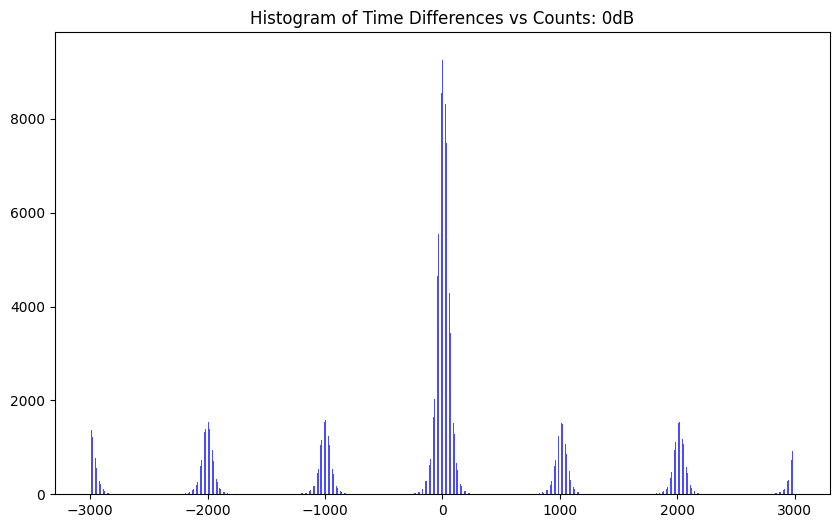

0dB: p = 79.3486, cc = 936467


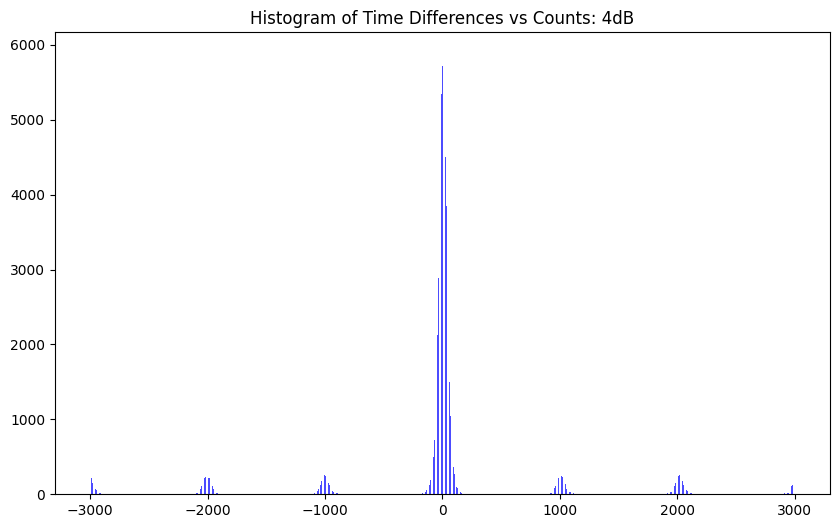

4dB: p = 20.7389, cc = 304239


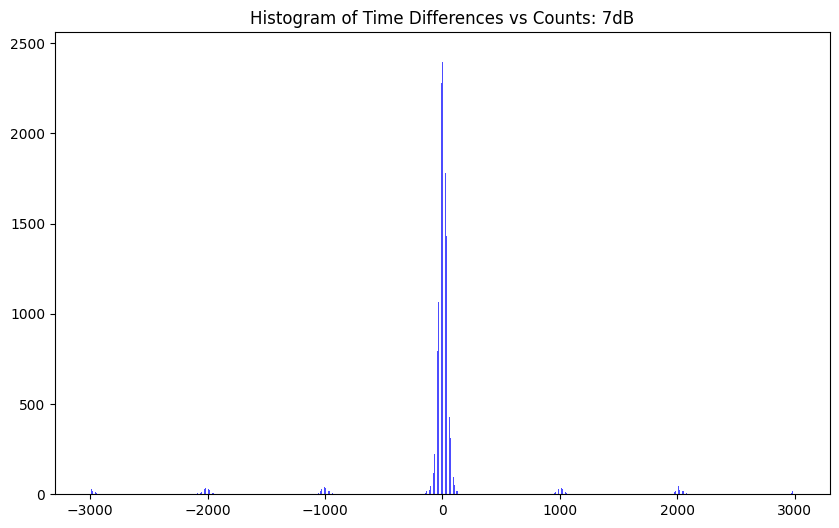

7dB: p = 6.8194, cc = 101456


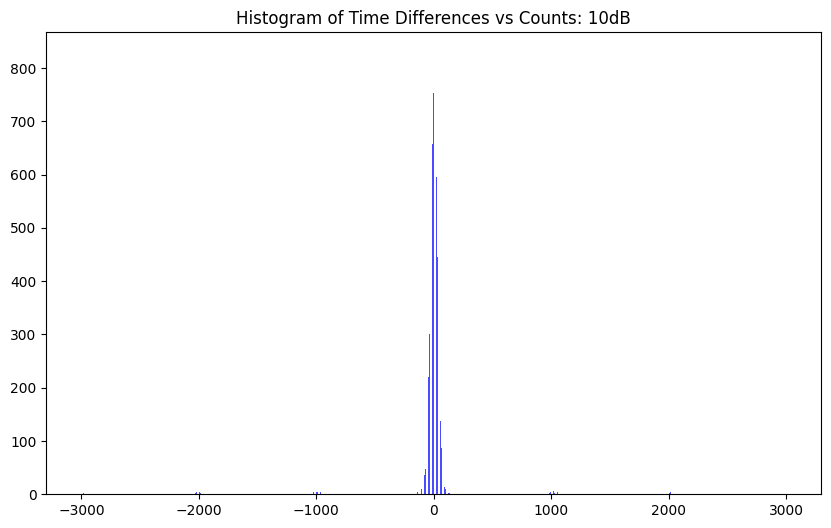

10dB: p = 2.4352, cc = 29697


In [13]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

COUNTS = "Counts per bin"
DT = "Time differences (ps)"

root = Path("C:/Users/nimro/Documents/code/iqis/iqislab/chip_data/chip_data/Fourwave mixing histograms")

def make_title(file_path: Path) -> str:
    return file_path.stem.split(" ")[0] + "dB"

def load_df(file_path: Path) -> pd.DataFrame:
    return pd.read_csv(
        file_path,
        delimiter="\t",
    )

def make_plot(df: pd.DataFrame, file_title: str):
    plt.figure(figsize=(10, 6))
    plt.bar(df[DT], df[COUNTS], width=1, color='blue', alpha=0.7)
    plt.title(f"Histogram of Time Differences vs Counts: {file_title}")
    plt.show()
    
    
    
"""
"""

margin = 200
rate = 1000


for file_path in [
                  root / "0 dB attenuation.txt",
                  root / "4 dB attenuation.txt",
                  root / "7 dB attenuation.txt",
                  root / "10 dB attenuation.txt"
                  ]:
    df = load_df(file_path)
    title = make_title(file_path)
    make_plot(df, title)
    big_peak = df[(df[DT]>=-200) & (df[DT]<=200)][COUNTS].sum()
    small_peaks = 0
    for i in [-3,-2,-1,1,2,3]:
        small_peaks += df[((df[DT]>=rate*i-margin) & (df[DT]<=rate*i+margin))][COUNTS].sum()
    coincidence_count = small_peaks + big_peak
    p = 100*small_peaks / big_peak
    print(f"{title}: p = {p:.4f}, cc = {coincidence_count}")



            ZZ        ZX        ZY        XZ        XX        XY        YZ  \
meas                                                                         
00    0.482115  0.264706  0.260057  0.187929  0.391369  0.244807  0.299854   
01    0.018663  0.236695  0.209770  0.270233  0.031250  0.229970  0.234352   
10    0.037325  0.168067  0.209770  0.337449  0.017857  0.321958  0.211063   
11    0.461897  0.330532  0.320402  0.204390  0.559524  0.203264  0.254731   

            YY        YX  
meas                      
00    0.023634  0.300912  
01    0.506647  0.193009  
10    0.438700  0.238602  
11    0.031019  0.267477  


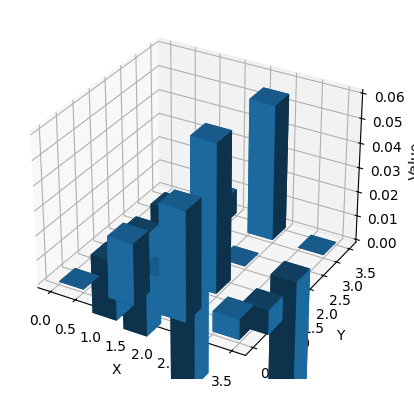

Fidelity: 0.9203


In [ ]:

from collections import defaultdict
from typing import List
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm


def prep_df(filepath: str):
    df = pd.read_excel(filepath)
    new_df = {"meas":[],"ZZ":[],"ZX":[],"ZY":[],"XZ":[],"XX":[],"XY":[],"YZ":[],"YY":[], "YX":[]}
    helper = defaultdict(dict)
    for col in df.columns:
        meas_base, meas = col[:2], col[2:]
        meas = {'1':'00','2':'01','3':'10','4':'11'}[meas]
        helper[meas][meas_base] = df.loc[0, col]
    for key, val in helper.items():
        new_df["meas"].append(key)
        for pauli, val2 in val.items():
            new_df[pauli].append(val2)
    df = pd.DataFrame(new_df).set_index("meas")
    return df / df.sum()

file_path="C:/Users/nimro/Documents/code/iqis/iqislab/chip_data/chip_data/Full Tomography Measurements/DensityMatrices_Fid_92.xlsx"

df = prep_df(file_path)
print(df)

def get(base: str, pauli: str):
    return df.iloc[[int(base, 2)]][pauli].values[0]


def comb(pauli: str, coef: List[int]):
    return sum(coef[i]*get(f"{i:02b}", pauli) for i in range(4))

IZ = comb("ZZ", [1, -1, 1, -1])
ZI = comb("ZZ", [1, 1, -1, -1])
ZZ = comb("ZZ", [1, -1, -1, 1])
IX = comb("ZX", [1, -1, 1, -1])
XI = comb("XZ", [1, 1, -1, -1])
XX = comb("XX", [1, -1, -1, 1])
IY = comb("ZY", [1, -1, 1, -1])
YI = comb("YZ", [1, 1, -1, -1])
YY = comb("YY", [1, -1, -1, 1])
ZX = comb("ZX", [1, -1, -1, 1])
ZY = comb("ZY", [1, -1, -1, 1])
XZ = comb("XZ", [1, -1, -1, 1])
XY = comb("XY", [1, -1, -1, 1])
YX = comb("YX", [1, -1, -1, 1])
YZ = comb("YZ", [1, -1, -1, 1])
II = comb("ZZ", [1, 1, 1, 1])


rho = 0.25 * np.array([
    [II + IZ + ZI + ZZ, IX - 1j*IY + ZX-1j*ZY, XI+XZ-1j*YI-1j*YZ, XX-1j*XY-1j*YX-YY],
    [IX + 1j*IY + ZX+1j*ZY, II - IZ + ZI - ZZ, XX+1j*XY-1j*YX+YY, XI-XZ+-1j*YI+1j*YZ],
    [XI + XZ + 1j*YI + 1j*YZ, XX - 1j*XY + 1j*YX+YY, II + IZ - ZI - ZZ, IX - 1j*IY - ZX + 1j*ZY],
    [XX + 1j*XY + 1j*YX-YY,XI-XZ+1j*YI-1j*YZ,IX+1j*IY-ZX-1j*ZY,II-IZ-ZI+ZZ]
])
sigma = 0.5*np.array([
    [1,0,0,1],
    [0,0,0,0],
    [0,0,0,0],
    [1,0,0,1]
    ])

data = np.real(rho)
xpos, ypos = np.meshgrid(np.arange(data.shape[0]), np.arange(data.shape[1]), indexing="ij")

# Flatten everything for plotting
xpos = xpos.ravel()
ypos = ypos.ravel()
zpos = np.zeros_like(xpos)

# Heights of the bars
dz = data.ravel()

# Width and depth of each bar
dx = dy = 0.5

# Create 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, shade=True)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Value')

plt.show()

def calculate_fidelity(rho, sigma):
    X = sqrtm(rho) @ sigma @ sqrtm(rho)
    # numerical cleanup to keep it Hermitian
    X = (X + X.conj().T) / 2
    return (np.real(np.trace(sqrtm(X))))**2

fidelity = calculate_fidelity(rho, sigma)
print(f"Fidelity: {fidelity.real:.4f}")